In [1]:
from datasets import load_dataset
import tensorflow as tf

# Povoliť eager execution (okamžité vykonávanie)
tf.compat.v1.enable_eager_execution()

# Skontrolovať, či je povolené 
print("Eager execution: ", tf.executing_eagerly())  # Toto by malo vytlačiť True


# Načítať dataset "hatexplain"
dataset = load_dataset("hatexplain")


2024-05-23 11:45:44.042501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-23 11:45:44.042546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Eager execution:  True


Found cached dataset hatexplain (/home/adam/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

In [3]:
train_dataset = dataset['train']
print(train_dataset[2])  

{'id': '1227920812235051008_twitter', 'annotators': {'label': [2, 2, 2], 'annotator_id': [209, 203, 222], 'target': [['Other'], ['Hindu'], ['Hindu', 'Other']]}, 'rationales': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], 'post_tokens': ['if', 'english', 'is', 'not', 'imposition', 'then', 'hindi', 'is', 'also', 'not', 'imposition', 'shut', 'up', 'chutiya', 'retards', 'stophindiimposition']}


In [4]:
#import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder

In [5]:
with open('dataset.json', 'r') as file:
    data = json.load(file)


In [6]:
# Vybrať trénovací dataset
train_dataset = dataset['train']

# Konvertovať trénovací dataset na DataFrame
df = pd.DataFrame(train_dataset)

# Keďže dataset obsahuje vnorené štruktúry (zoznamy a slovníky),
# je potrebné tieto štruktúry spracovať individuálne.


#'post_tokens' na reťazec (ak je potrebné) a vytvoriť jednoduchý DataFrame pre demonštráciu
df_simplified = pd.DataFrame({
    'id': [item['id'] for item in train_dataset],
    'label': [item['annotators']['label'][0] for item in train_dataset],  # Pre jednoduchosť berieme prvý label od anotátora
    'text': [' '.join(item['post_tokens']) for item in train_dataset]
})

# Teraz môžete skontrolovať chýbajúce údaje v tomto zjednodušenom DataFrame
missing_data = df_simplified.isnull().sum()
print(missing_data)


id       0
label    0
text     0
dtype: int64


In [6]:
texts = []
labels = []

# Pre každý príspevok v dátach extrahovať informácie
for post_id, post_info in data.items():
    
    text = " ".join(post_info['post_tokens'])
    
    # Získať label od prvého anotátora
    label = post_info['annotators'][0]['label']
    
    # Pridať text a label do zoznamov
    texts.append(text)
    labels.append(label)


In [7]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [9]:
print(X_test[33])

then hoes stole my choreo and still managed to make it look bad and lose with it lmfao


In [10]:
# Vytvoriť TfidfVectorizer s maximálnym počtom funkcií 10 000
vectorizer = TfidfVectorizer(max_features=10000)

# Transformovať trénovacie dáta na TF-IDF reprezentáciu a fitovať vektorizer
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transformovať testovacie dáta na TF-IDF reprezentáciu
X_test_tfidf = vectorizer.transform(X_test)


In [11]:
print(X_test_tfidf[0])

  (0, 9762)	0.13752277012152236
  (0, 9330)	0.4651238992480387
  (0, 8897)	0.17318305324918568
  (0, 8866)	0.06797877234817899
  (0, 7188)	0.2307961566092433
  (0, 6183)	0.121722279872378
  (0, 6075)	0.20612505148587823
  (0, 6070)	0.09451340357367445
  (0, 6015)	0.13237536148900222
  (0, 5507)	0.14236003423905125
  (0, 5284)	0.23556650121244288
  (0, 5262)	0.25008922437676384
  (0, 4835)	0.19069202761255155
  (0, 4567)	0.19180920749165564
  (0, 4539)	0.23220228054724998
  (0, 4187)	0.1344898992887898
  (0, 3427)	0.14474568212681455
  (0, 3016)	0.25492855052714236
  (0, 1335)	0.41378094845421864
  (0, 161)	0.22910749753645587


In [12]:
# Vytvoriť XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fitovať model na trénovacích dátach
xgb_classifier.fit(X_train_tfidf, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [13]:
# Predikovať hodnoty pre testovacie dáta pomocou modelu
y_pred = xgb_classifier.predict(X_test_tfidf)


print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Vytlačiť presnosť modelu
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

  hatespeech       0.71      0.61      0.65      1224
      normal       0.60      0.78      0.68      1615
   offensive       0.50      0.37      0.42      1191

    accuracy                           0.61      4030
   macro avg       0.60      0.58      0.58      4030
weighted avg       0.60      0.61      0.60      4030

Accuracy: 0.6057071960297766


In [14]:
# Ukážková veta na klasifikáciu
sample_sentence = "i am still sad i have been trying to make my phone work so it will take pictures the rooftops are all white in my neighborhood and it so lovely i hate my phone right now"

# Predspracovanie ukážkovej vety
sample_sentence_tfidf = vectorizer.transform([sample_sentence])

# Predikcia labelu pre ukážkovú vetu
predicted_label_num = xgb_classifier.predict(sample_sentence_tfidf)

# Dekódovanie numerického labelu na pôvodný label
predicted_label = label_encoder.inverse_transform(predicted_label_num)

print(f"The sentence is classified as: {predicted_label[0]}")

# Ukážková veta na klasifikáciu
sample_sentence = "then hoes stole my choreo and still managed to make it look bad and lose with it lmfao"

# Predspracovanie ukážkovej vety
sample_sentence_tfidf = vectorizer.transform([sample_sentence])

# Predikcia labelu pre ukážkovú vetu
predicted_label_num = xgb_classifier.predict(sample_sentence_tfidf)

# Dekódovanie numerického labelu na pôvodný label
predicted_label = label_encoder.inverse_transform(predicted_label_num)

print(f"The sentence is classified as: {predicted_label[0]}")

# Ukážková veta na klasifikáciu
sample_sentence = "exactly if a low iq nigger from africa who can not read can understand islam i think i can understand kill the kuffar nothing subtle lost on me"

# Predspracovanie ukážkovej vety
sample_sentence_tfidf = vectorizer.transform([sample_sentence])

# Predikcia labelu pre ukážkovú vetu
predicted_label_num = xgb_classifier.predict(sample_sentence_tfidf)

# Dekódovanie numerického labelu na pôvodný label
predicted_label = label_encoder.inverse_transform(predicted_label_num)

print(f"The sentence is classified as: {predicted_label[0]}")


The sentence is classified as: normal
The sentence is classified as: normal
The sentence is classified as: hatespeech


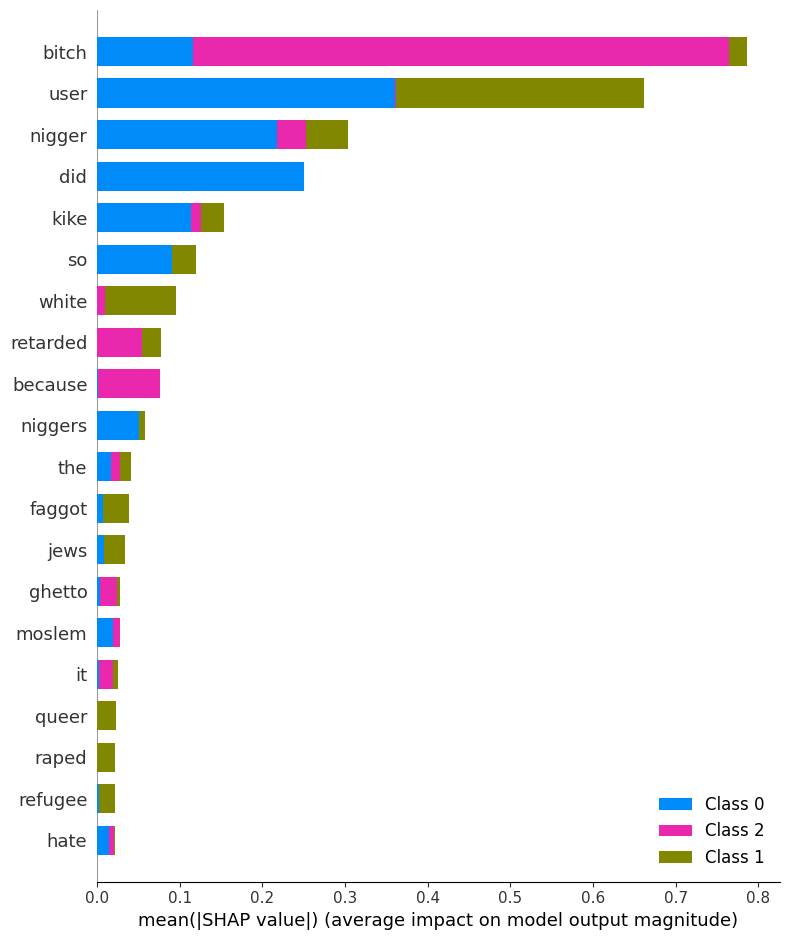

In [15]:
import shap

explainer = shap.Explainer(xgb_classifier)

shap_values = explainer.shap_values(X_test_tfidf[1])

shap.summary_plot(shap_values, X_test_tfidf[1], feature_names=vectorizer.get_feature_names_out())


 99%|===================| 11977/12090 [01:42<00:00]        

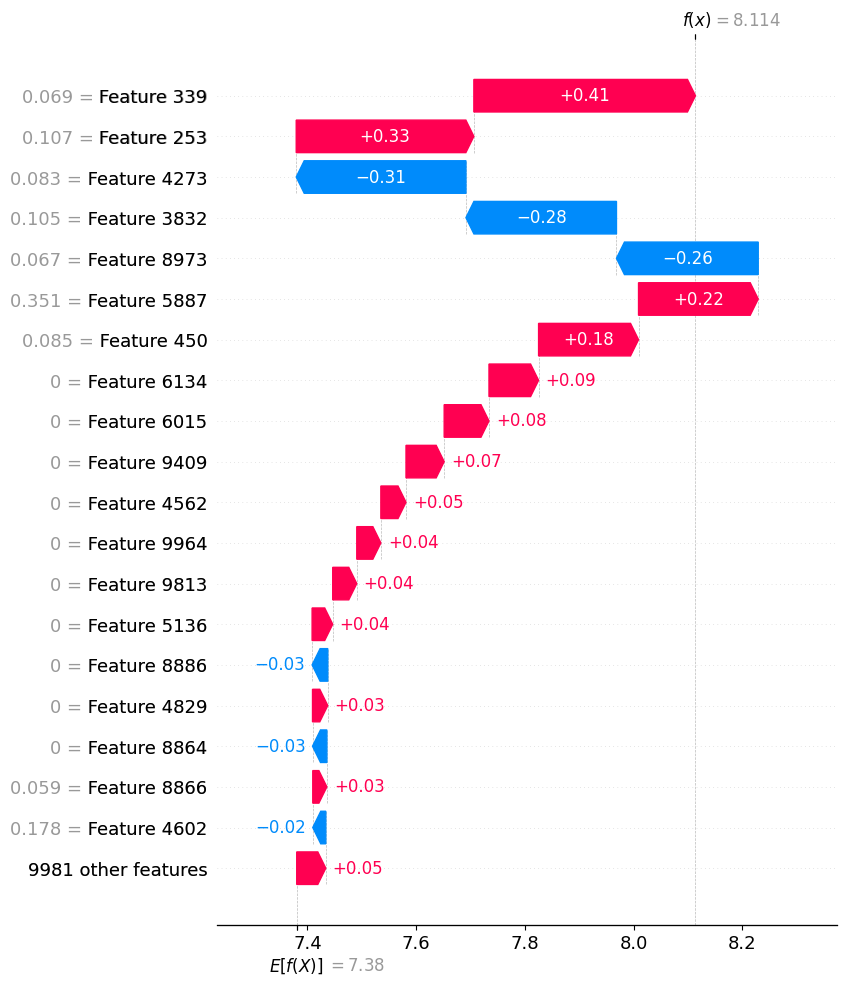

In [19]:
# Importovať knižnicu shap
import shap

# Konvertovať sparse matice na dense numpy array (len prvých 10 000 záznamov)
X_train_tfidf_dense = X_train_tfidf[:10000].toarray()
X_test_tfidf_dense = X_test_tfidf[:10000].toarray()

# Vytvoriť SHAP Explainer pre XGBClassifier na trénovacích dátach
explainer = shap.Explainer(xgb_classifier, X_train_tfidf_dense) 

# Vypočítať SHAP hodnoty pre testovacie dáta
shap_values = explainer(X_test_tfidf_dense)

# Importovať knižnicu matplotlib pre vykresľovanie grafov
import matplotlib.pyplot as plt

# Nastaviť veľkosť grafu
plt.figure(figsize=(12, 8))

# Generovať SHAP waterfall graf pre 66. vzorku, zobraziť maximálne 20 hodnôt
shap.plots.waterfall(shap_values[66,:,0], max_display=20)

# Zobraziť graf
plt.show()


In [17]:
# Získať názvy vlastností (features) z vectorizer-a
feature_names = vectorizer.get_feature_names_out()


In [18]:
print(X_test[0])

exactly if a low iq nigger from africa who can not read can understand islam i think i can understand kill the kuffar nothing subtle lost on me


In [19]:
# Získať index nenulových prvkov v 66. riadku testovacích dát
non_zero_indices = X_test_tfidf[66].nonzero()[1]

# Získať zodpovedajúce nenulové hodnoty
non_zero_values = X_test_tfidf[66].data 

# Vytlačiť nenulové vlastnosti a ich TF-IDF skóre
for idx, val in zip(non_zero_indices, non_zero_values):
    print(f"Feature: {feature_names[idx]}, Value: {val}")


Feature: work, Value: 0.18034036468398368
Feature: will, Value: 0.11984721065333884
Feature: white, Value: 0.09370097532640694
Feature: trying, Value: 0.18120918087308358
Feature: to, Value: 0.06689640931863519
Feature: the, Value: 0.05850148488243056
Feature: take, Value: 0.1643178858098588
Feature: still, Value: 0.16186717586762747
Feature: so, Value: 0.22709891166517795
Feature: sad, Value: 0.2044493195309283
Feature: right, Value: 0.14964673480509422
Feature: pictures, Value: 0.25944829938065234
Feature: phone, Value: 0.4765731114001983
Feature: now, Value: 0.14178836710453735
Feature: neighborhood, Value: 0.2424512052789041
Feature: my, Value: 0.3507516814108231
Feature: make, Value: 0.15440299479716718
Feature: lovely, Value: 0.2864310045420798
Feature: it, Value: 0.178041575100048
Feature: in, Value: 0.08297815838765375
Feature: have, Value: 0.10462872402709793
Feature: hate, Value: 0.13980284369624088
Feature: been, Value: 0.15362553490504227
Feature: are, Value: 0.084704725655

In [20]:
# Predpokladajme, že 'shap_values' je korektne načítaná
selected_shap_values = shap_values[66]  # Výber SHAP hodnôt pre 66. príklad

# Zobrazenie SHAP hodnôt pre ne-nulové prvky
non_zero_shap_values = selected_shap_values.values[non_zero_indices]

# Vytlačiť ne-nulové vlastnosti a ich SHAP hodnoty
for idx, shap_val in zip(non_zero_indices, non_zero_shap_values):
    print(f"Feature: {feature_names[idx]}, SHAP Value: {shap_val}")


Feature: work, SHAP Value: [0. 0. 0.]
Feature: will, SHAP Value: [0.00651964 0.00143315 0.        ]
Feature: white, SHAP Value: [-0.00559767  0.04670288 -0.00377942]
Feature: trying, SHAP Value: [0. 0. 0.]
Feature: to, SHAP Value: [-0.26072325 -0.06708448 -0.07892008]
Feature: the, SHAP Value: [ 0.02594339 -0.30567717  0.32179268]
Feature: take, SHAP Value: [ 0.         0.        -0.0003962]
Feature: still, SHAP Value: [0. 0. 0.]
Feature: so, SHAP Value: [0.02302748 0.02714197 0.        ]
Feature: sad, SHAP Value: [0. 0. 0.]
Feature: right, SHAP Value: [0.01781373 0.         0.        ]
Feature: pictures, SHAP Value: [0. 0. 0.]
Feature: phone, SHAP Value: [0. 0. 0.]
Feature: now, SHAP Value: [-0.00092942  0.00327613  0.        ]
Feature: neighborhood, SHAP Value: [0. 0. 0.]
Feature: my, SHAP Value: [ 2.20127631e-01 -4.62128894e-01  4.36111987e-04]
Feature: make, SHAP Value: [0. 0. 0.]
Feature: lovely, SHAP Value: [0. 0. 0.]
Feature: it, SHAP Value: [-0.02396129  0.0115271  -0.00280806]

Current feature names: None


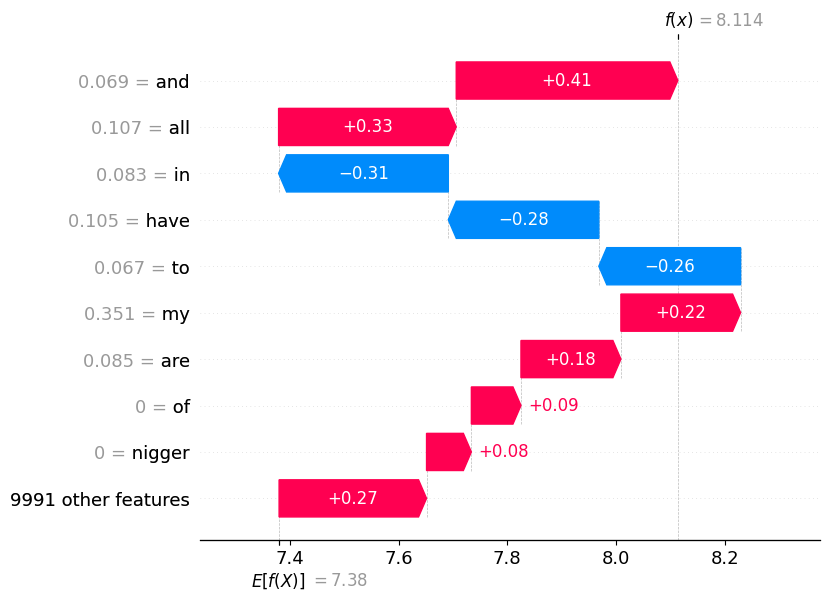

<Figure size 1200x800 with 0 Axes>

In [21]:
import shap
import matplotlib.pyplot as plt

# Predpokladajme, že 'shap_values' sú korektne vypočítané
selected_shap_values = shap_values[66, :, 0]  

# Skontrolovať, či sú názvy vlastností správne nastavené v objekte Explanation
print("Current feature names:", selected_shap_values.feature_names)

# Ak nie, nastaviť názvy vlastností priamo v objekte Explanation
if selected_shap_values.feature_names is None or len(selected_shap_values.feature_names) != len(feature_names):
    selected_shap_values.feature_names = feature_names

# Teraz vygenerovať waterfall graf s názvami vlastností priamo pomocou objektu Explanation
shap.plots.waterfall(selected_shap_values, max_display=10)

# Nastaviť veľkosť grafu a zobraziť ho
plt.figure(figsize=(12, 8))
plt.show()


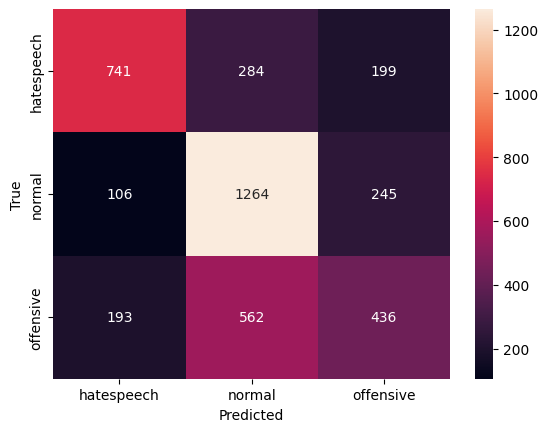

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vytvoriť confusion matrix na základe skutočných a predikovaných hodnôt
cm = confusion_matrix(y_test, y_pred)

# Vykresliť maticu ako heatmapu s anotáciami
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Nastaviť popisky osí
plt.xlabel('Predikované')
plt.ylabel('Skutočné')

# Zobraziť graf
plt.show()


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import json

Najčastejšie slová a ich frekvencie:
the: 16028
a: 10966
to: 10332
and: 9504
i: 7658
<user>: 7458
you: 7101
of: 6965
is: 6533
not: 5703


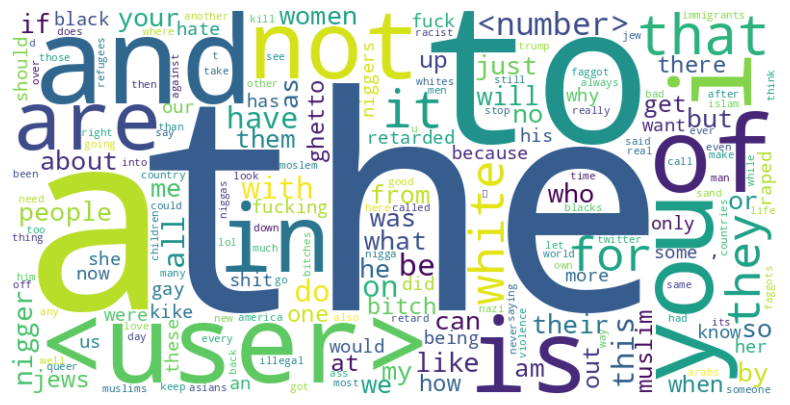

In [28]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Získať všetky tokeny zo všetkých príspevkov
all_tokens = []
for post_id, post_data in data.items():
    all_tokens.extend(post_data["post_tokens"])

# Spočítať frekvencie jednotlivých tokenov
token_counts = Counter(all_tokens)

# Získať 10 najčastejších tokenov
most_common_tokens = token_counts.most_common(10)
print("Najčastejšie slová a ich frekvencie:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")

# Vytvoriť word cloud na základe frekvencií tokenov
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)

# Zobraziť word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [24]:
import json
import shap
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from doxpy.models.knowledge_extraction.knowledge_graph_extractor import KnowledgeGraphExtractor
from doxpy.models.estimation.dox_estimator import DoXEstimator
from doxpy.models.knowledge_extraction.knowledge_graph_manager import KnowledgeGraphManager
from doxpy.models.reasoning.answer_retriever import AnswerRetriever

# Vysvetlenie predikcií modelu pomocou SHAP
explainer = shap.Explainer(xgb_classifier, X_train_tfidf_dense)
shap_values = explainer(X_test_tfidf_dense[:100])  # Obmedzenie na prvých 100 vzoriek pre vysvetlenie

# Generovanie textových vysvetlení zo SHAP hodnôt
def generate_explanation(shap_values, feature_names, index):
    explanation = f"Prediction for instance {index}:\n"
    explanation += f"Base value: {shap_values.base_values[index]}\n"
    for i, feature in enumerate(feature_names):
        explanation += f"Feature: {feature}, SHAP Value: {shap_values.values[index, i]}\n"
    return explanation

# Konvertovanie SHAP hodnôt na vysvetlenia v prirodzenom jazyku
explanations = [generate_explanation(shap_values, vectorizer.get_feature_names_out(), i) for i in range(len(shap_values.values))]

# Uloženie vysvetlení do súboru
with open('explanations.txt', 'w') as f:
    for explanation in explanations:
        f.write(explanation + "\n")

# Definovanie aspektov vysvetlenia 
EXPLANANDUM_ASPECTS = ["feature", "SHAP Value", "prediction", "base value"]

# Načítanie vysvetlení
with open('explanations.txt', 'r') as file:
    explanations = file.readlines()

# Konfigurácia pre DoXpy
PHI = explanations[:100]  # Obmedzenie na prvých 100 vysvetlení pre výpočet

answer_pertinence_threshold = 0.15

ARCHETYPE_FITNESS_OPTIONS = {
    'one_answer_per_sentence': False,
    'answer_pertinence_threshold': answer_pertinence_threshold, 
    'answer_to_question_max_similarity_threshold': None,
    'answer_to_answer_max_similarity_threshold': 0.85,
}

KG_MANAGER_OPTIONS = {
    'spacy_model': 'en_core_web_trf',
    'n_threads': 1,
    'with_cache': False,
    'with_tqdm': False,
}

KG_BUILDER_DEFAULT_OPTIONS = {
    'spacy_model': 'en_core_web_trf',
    'n_threads': 1,
    'with_cache': False,
    'with_tqdm': False,
    'max_syntagma_length': None,
    'add_source': True,
    'add_label': True,
    'lemmatize_label': False,
    'default_similarity_threshold': 0,
    'tf_model': {
        'url': 'https://tfhub.dev/google/universal-sentence-encoder-large/5',  # Transformer
    },
}

CONCEPT_CLASSIFIER_DEFAULT_OPTIONS = {
    'spacy_model': 'en_core_web_trf',
    'n_threads': 1,
    'default_batch_size': 20,
    'with_tqdm': False,
    'tf_model': {
        'url': 'https://tfhub.dev/google/universal-sentence-encoder-large/5',  # Transformer
    },
    'default_similarity_threshold': 0.5,
}

SENTENCE_CLASSIFIER_DEFAULT_OPTIONS = {
    'spacy_model': 'en_core_web_trf',
    'n_threads': 1,
    'sbert_model': {
        'url': 'multi-qa-MiniLM-L6-cos-v1',
        'with_cache': True,
    },
    'with_tqdm': False,
    'with_cache': False,
    'default_tfidf_importance': 0,
}

# Inicializácia dátových štruktúr
explainable_information_graph = KnowledgeGraphExtractor(KG_BUILDER_DEFAULT_OPTIONS).set_content_list(PHI, remove_stopwords=False, remove_numbers=False, avoid_jumps=True).build()

kg_manager = KnowledgeGraphManager(KG_MANAGER_OPTIONS, explainable_information_graph)
qa = AnswerRetriever(
    kg_manager=kg_manager, 
    concept_classifier_options=CONCEPT_CLASSIFIER_DEFAULT_OPTIONS, 
    sentence_classifier_options=SENTENCE_CLASSIFIER_DEFAULT_OPTIONS,
)

# Definovanie archetypálnych otázok
question_template_list = [
    'What is the context of {X}?',
    'Who is targeted by {X}?',
    'How is {X} expressed?',
    'Where is {X} commonly found?',
    'When does {X} occur?',
    'Which groups are affected by {X}?',
    'Whose responsibility is to address {X}?',
    'Who is {X}?',
    'In what manner is {X} delivered?',
    'What is the reason for {X}?',
    'What is the impact of {X}?',
    'What is an example of {X}?',
    'After what event does {X} typically occur?',
    'While discussing what topics does {X} arise?',
    'In what case is {X} more prevalent?',
    'Despite what measures does {X} persist?',
    'What is contrasted with {X}?',
    'Before what situation does {X} increase?',
    'Since when has {X} been a problem?',
    'What is similar to {X}?',
    'Until when does {X} go unnoticed?',
    'Instead of what, is {X} used?',
    'What is an alternative to {X}?',
    'Except in what context, is {X} considered acceptable?',
    '{X}, unless what?',
]

# Definovanie generátora otázok
question_generator = lambda question_template, concept_label: question_template.replace('{X}', concept_label)

# Inicializácia DoX estimátora
dox_estimator = DoXEstimator(qa)

# Odhad DoX
dox = dox_estimator.estimate(
    aspect_uri_iter=list(EXPLANANDUM_ASPECTS), 
    query_template_list=question_template_list, 
    question_generator=question_generator,
    **ARCHETYPE_FITNESS_OPTIONS, 
)
print(f'DoX:', json.dumps(dox, indent=4))

# Výpočet priemerného DoX
average_dox = dox_estimator.get_weighted_degree_of_explainability(dox, archetype_weight_dict=None)
print('Average DoX:', average_dox)


DoX: {
    "{X}, unless what?": 0.3997127413749695,
    "How is {X} expressed?": 0.39775750041007996,
    "What is similar to {X}?": 0.38620075583457947,
    "Instead of what, is {X} used?": 0.3854964077472687,
    "Who is {X}?": 0.38070517778396606,
    "In what manner is {X} delivered?": 0.3672280013561249,
    "What is an alternative to {X}?": 0.3498862683773041,
    "What is an example of {X}?": 0.3495257794857025,
    "What is contrasted with {X}?": 0.34001418948173523,
    "When does {X} occur?": 0.33756333589553833,
    "Where is {X} commonly found?": 0.3324109613895416,
    "What is the context of {X}?": 0.3298259973526001,
    "What is the reason for {X}?": 0.325699120759964,
    "What is the impact of {X}?": 0.3161105513572693,
    "Before what situation does {X} increase?": 0.31033024191856384,
    "Who is targeted by {X}?": 0.307605504989624,
    "Since when has {X} been a problem?": 0.3073504567146301,
    "In what case is {X} more prevalent?": 0.2887284457683563,
    "Aft

In [ ]:
@article{sovrano2023objective,
  title={An objective metric for explainable AI: how and why to estimate the degree of explainability},
  author={Sovrano, Francesco and Vitali, Fabio},
  journal={Knowledge-Based Systems},
  volume={278},
  pages={110866},
  year={2023},
  publisher={Elsevier}
}